In [38]:
import torch
import pickle
import math
import random
import json

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from tqdm import tqdm
from typing import List, Tuple
from torch.utils.data import Dataset, DataLoader
from transformers import (BertTokenizer,
                          BertForSequenceClassification, 
                          Trainer, 
                          TrainingArguments)

device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
class SentimentData(Dataset):
    def __init__(self, 
                 dataset: List[Tuple[str, int]],
                 tokenizer):
    
        super().__init__()
        mapping = {0: "negative",
                   1: "positive"}
        
        self.tokenizer = tokenizer
        ## Assumption: positive has value 1 and negative has value 0
        self.texts = [_[0] for _ in dataset]
        self.values = [_[1] for _ in dataset]
        self.labels = [mapping[_[1]] for _ in dataset]
        
        assert len(self.texts)==len(self.labels)
        
    def __getitem__(self, idx):
        X = self.tokenizer(self.texts[idx], 
                           padding="max_length", 
                           truncation=True,
                           return_tensors='pt')
        
        for k, v in X.items():
            X[k] = v.squeeze()
        
        
#         X['labels'] = torch.Tensor([0, 0])
#         X['labels'][self.values[idx]] = 1
        X['labels'] = torch.Tensor([self.values[idx]])
        
        return X
    
    def __len__(self):
        return len(self.texts)

In [3]:
def load_dataset(
    dataset_paths: List[str],
    tokenizer
) -> Tuple[SentimentData, SentimentData, SentimentData]:
    
    train_set, val_set, test_set = [], [], []
    for dataset_path in tqdm(dataset_paths, desc="Processing files"):
        if "pos" in dataset_path:
            target=1
        else:
            target=0

        with open(dataset_path, "rb") as f:
            texts = f.read().decode("utf-8", errors="ignore").split("\n")
            texts = [_.strip() for _ in texts]
        
        labels = [target for _ in range(len(texts))]
        
        train_set += [(_1, _2) for _1, _2 in zip(texts[:4000], labels[:4000])]
        val_set += [(_1, _2) for _1, _2 in zip(texts[4000:4500], labels[4000:4500])]
        test_set += [(_1, _2) for _1, _2 in zip(texts[4500:], labels[4500:])]
    
    
    print("Length of train set: ", len(train_set))
    print("Length of val set: ", len(val_set))
    print("Length of test set: ", len(test_set))
    
    random.shuffle(train_set)
    random.shuffle(val_set)
    random.shuffle(test_set)
    
    return {"train": SentimentData(train_set, tokenizer),
            "val": SentimentData(val_set, tokenizer),
            "test": SentimentData(test_set, tokenizer)}

In [9]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=1).to(device)

tokenizer

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertTokenizer(name_or_path='bert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

In [10]:
dataset_paths = ["/kaggle/input/sentiment-polarity/rt-polarity.neg",
                 "/kaggle/input/sentiment-polarity/rt-polarity.pos"]

datasets = load_dataset(dataset_paths, tokenizer)

Processing files: 100%|██████████| 2/2 [00:00<00:00, 157.72it/s]

Length of train set:  8000
Length of val set:  1000
Length of test set:  1664


In [17]:
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        # Extract labels from the inputs
        labels = inputs.get("labels")
        
        # Forward pass: get model output
        outputs = model(**inputs)
        logits = outputs.get("logits")
        logits = torch.nn.functional.sigmoid(logits)
        
        # Calculating Loss
        loss_fct = torch.nn.BCEWithLogitsLoss()
        loss = loss_fct(logits, labels)
        
        return (loss, outputs) if return_outputs else loss

In [35]:
training_arguments = TrainingArguments(
    output_dir="/kaggle/working/bert-base",
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=2,
    learning_rate=5e-5,
    logging_steps=50,
    save_total_limit=15,
    eval_strategy="steps",
    eval_steps=100,
    save_steps=100,
    optim="adamw_torch"
)

trainer = CustomTrainer(
    model=model,
    args=training_arguments,
    train_dataset=datasets['train'],
    eval_dataset=datasets['val']
)

In [ ]:
trainer.train()

## Evaluating Model

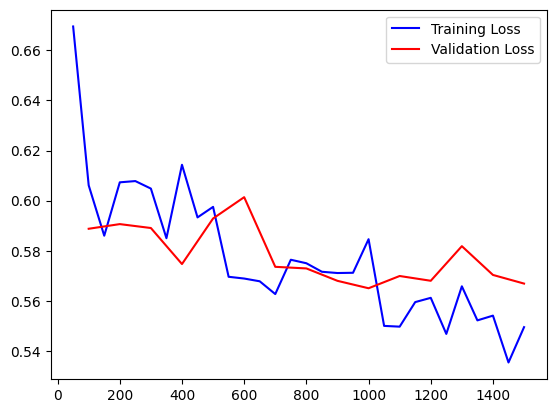

In [20]:
def plot_loss(trainer_state_path: str):
    training_loss, val_loss = [], []
    with open(trainer_state_path, "r") as f:
        logs = json.load(f)['log_history']

    for _log in logs:
        if 'eval_loss' in _log:
            val_loss.append((_log['step'], _log['eval_loss']))
        else:
            training_loss.append((_log['step'], _log['loss']))
    
    plt.plot([_[0] for _ in training_loss],
             [_[1] for _ in training_loss], 
             label="Training Loss",
             color="blue")
    
    plt.plot([_[0] for _ in val_loss],
             [_[1] for _ in val_loss], 
             label="Validation Loss",
             color="red")
    
    plt.legend()
    plt.show()

plot_loss("/kaggle/working/bert-base/checkpoint-1500/trainer_state.json")

In [33]:
## Taking the last checkpoint as the best model
test_dataloader = DataLoader(datasets['test'], shuffle=False, batch_size=8, drop_last=False)

predictions = []
for data in tqdm(test_dataloader, desc="Obtaining Predictions", total=math.ceil(len(datasets['test'])/8)):
    with torch.no_grad():
        for k, v in data.items():
            data[k] = v.to(device)
            
        x = model(**data)
        
        predictions.extend(list((torch.nn.functional.sigmoid(x.logits).squeeze() >= 0.5)*1))
        predictions = [int(_) for _ in predictions]

Obtaining Predictions: 100%|██████████| 208/208 [00:28<00:00,  7.34it/s]


True Positives (TP): 674
True Negatives (TN): 690
False Positives (FP): 142
False Negatives (FN): 158
Precision: 0.83
Recall: 0.81
F1-Score: 0.82


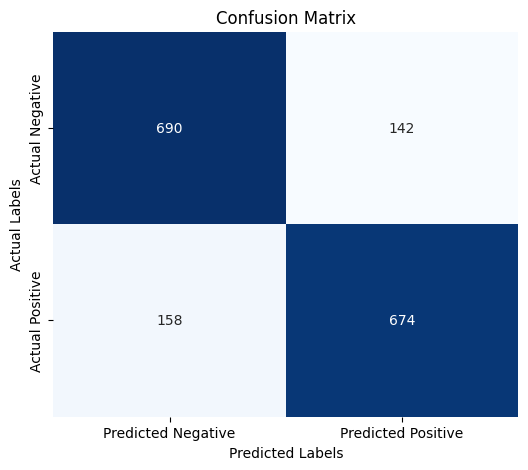

In [39]:
# Function to calculate TP, TN, FP, FN
def calculate_confusion_matrix(predictions: List[int], labels: List[int]):
    TP = sum((p == 1 and l == 1) for p, l in zip(predictions, labels))
    TN = sum((p == 0 and l == 0) for p, l in zip(predictions, labels))
    FP = sum((p == 1 and l == 0) for p, l in zip(predictions, labels))
    FN = sum((p == 0 and l == 1) for p, l in zip(predictions, labels))
    return TP, TN, FP, FN

# Function to calculate precision
def calculate_precision(TP, FP):
    return TP / (TP + FP) if (TP + FP) > 0 else 0

# Function to calculate recall
def calculate_recall(TP, FN):
    return TP / (TP + FN) if (TP + FN) > 0 else 0

# Function to calculate F1 score
def calculate_f1_score(precision, recall):
    return 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

# Function to print the metrics
def print_metrics(TP, TN, FP, FN, precision, recall, f1_score):
    print(f"True Positives (TP): {TP}")
    print(f"True Negatives (TN): {TN}")
    print(f"False Positives (FP): {FP}")
    print(f"False Negatives (FN): {FN}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1-Score: {f1_score:.2f}")

# Function to plot the confusion matrix
def plot_full_confusion_matrix(TP, TN, FP, FN):
    # Create confusion matrix array
    confusion_matrix = np.array([[TN, FP], [FN, TP]])

    # Plotting the confusion matrix using seaborn heatmap
    plt.figure(figsize=(6, 5))
    sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, 
                xticklabels=["Predicted Negative", "Predicted Positive"], 
                yticklabels=["Actual Negative", "Actual Positive"])
    
    # Add labels and title
    plt.xlabel('Predicted Labels')
    plt.ylabel('Actual Labels')
    plt.title('Confusion Matrix')
    
    # Show the plot
    plt.show()

# Main function to calculate and display all metrics
def evaluate_model(predictions: List[int], labels: List[int]):
    # Step 1: Calculate TP, TN, FP, FN
    TP, TN, FP, FN = calculate_confusion_matrix(predictions, labels)
    
    # Step 2: Calculate Precision, Recall, F1-Score
    precision = calculate_precision(TP, FP)
    recall = calculate_recall(TP, FN)
    f1_score = calculate_f1_score(precision, recall)
    
    # Step 3: Print metrics
    print_metrics(TP, TN, FP, FN, precision, recall, f1_score)
    
    # Step 4: Plot confusion matrix components
    plot_full_confusion_matrix(TP, TN, FP, FN)

# Run the evaluation
evaluate_model(predictions, datasets['test'].values)